In [1]:
import numpy.random as rnd
import scipy.spatial
import networkx as nx
from networkx.algorithms.dominating import dominating_set
from numpy import array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.figsize'] = (15, 15)
from shapely.geometry import MultiPoint, Point
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from shapely.geometry import LineString

In [2]:
def delGraph(points):
    delTri = scipy.spatial.Delaunay(points) 

    # create a set for edges that are indexes of the points 
    edges = set() 
    # for each Delaunay triangle 
    for n in range(delTri.nsimplex): 
        # for each edge of the triangle 
        # sort the vertices 
        # (sorting avoids duplicated edges being added to the set) 
        # and add to the edges set 
        edge = sorted([delTri.vertices[n,0], delTri.vertices[n,1]]) 
        edges.add((edge[0], edge[1])) 
        edge = sorted([delTri.vertices[n,0], delTri.vertices[n,2]]) 
        edges.add((edge[0], edge[1])) 
        edge = sorted([delTri.vertices[n,1], delTri.vertices[n,2]]) 
        edges.add((edge[0], edge[1]))
    return edges

def euclideanDist(a, b):
    return np.sqrt((a[0]-b[0])*(a[0]-b[0])+(a[1]-b[1])*(a[1]-b[1]))

def udgGraph(graph_original, points, max_dist):
    graph = graph_original.copy()
    edges = graph.edges()
    removed_edges = []
    for edge in edges:
        i, j = edge
        dist = scipy.spatial.distance.euclidean(points[i], points[j])
        if dist > max_dist:
            graph.remove_edge(*edge)
            removed_edges.append(edge)
    percent_removed = 100. * (float(len(edges)-len(graph.edges()))/float(len(edges)))
    print(str(percent_removed)+"%")
    return graph, removed_edges

def removeSpannedRegion(region, graph, points):
    G = graph.copy()
    for n in graph.nodes():
        p = points[n]
        if (region[0][0] < p[0] < region[0][1]) and (region[1][0] < p[1] < region[1][1]):
            for s in G.neighbors(n):
                G.remove_edge(n,s)
    return G

# Find all points within bounding convex hull
def in_hull(p, hull):
    if not isinstance(hull,scipy.spatial.Delaunay):
        hull = scipy.spatial.Delaunay(hull)
    return hull.find_simplex(p)>=0

def removeSpannedConvexRegion(region, graph, points):
    G = graph.copy()
    for n in graph.nodes():
        p = points[n]
        if in_hull(p, region):
            for s in G.neighbors(n):
                G.remove_edge(n,s)
    return G

def extractSpannedConvexRegion(region, graph, points):
    G = graph.copy()
    for n in graph.nodes():
        p = points[n]
        if not in_hull(p, region):
            for s in G.neighbors(n):
                G.remove_edge(n,s)
    return G

def parePointSet(region, points):
    valid_points = []
    for p in points:
        if not in_hull(p, region):
            valid_points.append(p)
    return valid_points

def parePointSetPoly(poly_region, points):
    valid_points = []
    for p in points:
        if not poly_region.contains(Point(p)):
            valid_points.append(p)
    return valid_points

In [3]:
class Triangle:
    def __init__(self, ptA, ptB, ptC):
        self.ptA = ptA
        self.ptB = ptB
        self.ptC = ptC
    def __eq__(self, other):
        self_pts = sorted([self.ptA, self.ptB, self.ptC], key=lambda pt: pt[0])
        other.pts = sorted([other.ptA, other.ptB, other.ptC], key=lambda pt: pt[0])
        return self_pts == other.pts
    def get_edges(self):
        return [self.ptA, self.ptB, self.ptC]
    def has_point(self, point):
        ##if (self.ptA == point or self.ptA == point[::-1]) or (self.ptB == point or self.ptB == point[::-1]) or (self.ptC == point or self.ptC == point[::-1]):
        ##    return True
        return False
    def has_edge(self, a, b):
        return self.has_point(a) and self.has_point(b)

In [4]:
## Generate base
network_size = 5000
points = rnd.uniform(0.,1.,[network_size, 2])
point_map = dict(zip(range(len(points)), points))

## Define region as a set of points to form a convex area

## Another polygon hole (spiral)
##polys = [Polygon([(0.9,0.9),(0.1,0.9),(0.1,0.1),(0.9,0.1),(0.9,0.7),(0.3,0.7),(0.3,0.4),(0.5,0.4),(0.5,0.6),(0.8,0.6),(0.8,0.2),(0.2,0.2),(0.2,0.8),(0.9,0.8)])]


##polys = [Polygon([(0.2,0.9), (0.7,0.9), (0.8,0.8), (0.9,0.75), (0.4,0.3), (0.9,0.25), (0.9,0.1), (0.2,0.3), (0.4,0.4), (0.6,0.8)])]
##udg_dist = 0.065
## Starry thing
#piece = np.matrix([(0.5,0.6),(0.75,0.75),(0.65,0.6),(0.55,0.5),(0.67,0.2),(0.7,0.1),(0.6,0.15),(0.5,0.3)]) #0.1/dist
#udg_dist = 0.1
piece = np.matrix([(0.46,0.5),(0.54,0.5),(0.54,0.6),(0.5,1.0),(0.46,0.76)])
udg_dist = 0.065
#t_primary_mat = np.matrix([0,-0.2])
#piece = piece#+t_primary_mat
t_mat = np.matrix([0.5,0.5])
r_deg = 2*np.pi/5
r_mat = np.matrix([[np.cos(r_deg), -1.*np.sin(r_deg)], [np.sin(r_deg), np.cos(r_deg)]])
polys = []# [Point(0.5,0.65).buffer(0.15)]
rep_polys = [piece]
for i in range(5):
    next_point = (rep_polys[-1]-t_mat)*r_mat+t_mat
    rep_polys.append(next_point)
for p in rep_polys:
    polys.append(Polygon(p))

## Create interesting polygons
#center_circle = Point(0.5,0.5).buffer(0.03)
#polys = [center_circle]
#icicle_pts = np.matrix([[0.5,0.45],[0.65,0.45],[0.9,0.45],[0.9,0.55],[0.65,0.55],[0.5,0.55]])
#rep_polys = [icicle_pts]
#t_mat = np.matrix([0.5,0.5])
#r_deg = np.pi/3
#r_mat = np.matrix([[np.cos(r_deg), -1.*np.sin(r_deg)], [np.sin(r_deg), np.cos(r_deg)]])
#for i in range(6):
#    next_point = (rep_polys[-1]-t_mat)*r_mat+t_mat
#    rep_polys.append(next_point)
#for p in rep_polys:
#    polys.append(Polygon(p))

## Pare down w/ polygon approach
for poly in polys:
    points = parePointSetPoly(poly, points)

## Pare down generated points
#orig_points = points
#for shape in star_points:
#    points = parePointSet(shape, points)
#points = parePointSet(interior_area, points)

## Generate delaunay triangulaion

base_graph = nx.Graph()
base_graph.add_edges_from(delGraph(points))
full_graph = nx.Graph()
full_graph.add_edges_from(delGraph(points))

## Generate LDG
udg_graph, removed_edges = udgGraph(base_graph, points, udg_dist)

udg_points = [points[p] for p in udg_graph.nodes()]

region_graph = udg_graph.copy()


## Subtract
hole_graph = nx.difference(full_graph, region_graph)

## Del triangulation of hole graph
triangle_hole_graph = nx.Graph()

triangle_nodes = [n for n in hole_graph.nodes() if hole_graph.degree(n)>0]
triangle_points = [points[n] for n in hole_graph.nodes() if hole_graph.degree(n)>0]
triangle_edges = delGraph(triangle_points)
triangle_hole_graph.add_nodes_from(hole_graph.nodes())
for e in triangle_edges:
    triangle_hole_graph.add_edge(triangle_nodes[e[0]], triangle_nodes[e[1]])

## Find symmetric difference
path_around_chain = nx.difference(triangle_hole_graph, hole_graph)
path_around_chain = nx.intersection(base_graph, path_around_chain)
print(len(hole_graph.edges()))
print(len(path_around_chain.edges()))
    


1.5277671682835536%
200
140


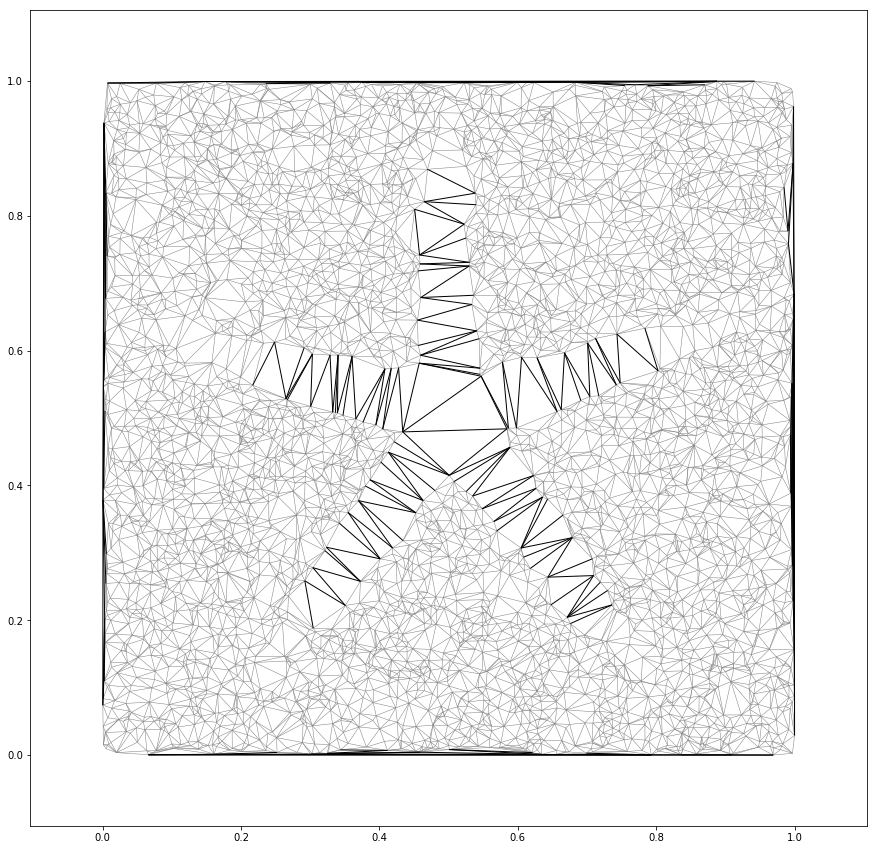

In [5]:
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=0.5, edge_color='gray')
nx.draw_networkx_edges(hole_graph, pos=points, width=1.0, edge_color='black')
plt.show()

In [6]:
## Convex Hull boundaries
def convexHull(hole_graph, points):
    nodes = []
    pts = []
    for n in [x for x in hole_graph.nodes() if hole_graph.degree(x)>0]:
        nodes.append(n)
        pts.append(points[n])
    cx_hull = scipy.spatial.ConvexHull(pts)
    cx_graph = nx.Graph()
    for edge in zip(cx_hull.vertices, cx_hull.vertices[1:]):
        s, t = edge
        cx_graph.add_edge(nodes[s], nodes[t])
    cx_graph.add_edge(nodes[cx_hull.vertices[-1]],nodes[cx_hull.vertices[0]])
    return cx_graph

## Convex Hull from hole shape
def convexHullFromShapes(shapes):
    contained_points = []
    for shape in shapes:
        for point in list(shape):
            contained_points.append(point)
    cx_hull = scipy.spatial.ConvexHull(np.array(contained_points))
    cx_graph = nx.Graph()
    for edge in zip(cx_hull.vertices, cx_hull.vertices[1:]):
        cx_graph.add_edge(*edge)
    cx_graph.add_edge(cx_hull.vertices[-1],cx_hull.vertices[0])
    return (cx_graph, contained_points)

In [7]:
def externalPath(graph):
    exterior_graph = nx.Graph()
    triangles = []
    edge_freq = dict()
    for v in graph.nodes():
        curr_triangles = []
        for n in graph.neighbors(v):
            for t in graph.neighbors(n):
                if graph.has_edge(t,v):
                    # v,n,t is a Triangle
                    triangle_edges = [(v,n),(n,t),(t,v)]
                    triangle_this = Triangle(*triangle_edges)
                    if triangle_this not in triangles:
                        triangles.append(triangle_this)
                        for edge in triangle_edges:
                            try:
                                edge_freq[edge] += 1
                            except KeyError:
                                edge_freq[edge] = 1
    for edge in edge_freq.keys():
        if edge_freq[edge] == 1:
            exterior_graph.add_edge(*edge)
    return exterior_graph

In [8]:
def genExtGraph(path_longest, udg_graph=udg_graph):
    # Use vertices from connected component of hole_graph object
    triangle_chain = []
    exterior_edges = []
    interior_edges = []
    # Iterate through vertices of largest connected component
    for v in path_longest.nodes():
        # Iterate through each neighbor within the connected component
        curr_triangles = []
        for n in path_longest.neighbors(v):
            # Follow this edge first
            # Find neighbors of n on udg and on path_longest
            for t in udg_graph.neighbors(n)+path_longest.neighbors(n):
                if udg_graph.has_edge(t,v) or path_longest.has_edge(t,v):
                    # This is a valid triangle
                    curr_tri = Triangle((v,n),(n,t),(t,v))
                    if curr_tri not in triangle_chain:
                        triangle_chain.append(curr_tri)
                    for curr_edge in curr_tri.get_edges():
                        rev_edge = curr_edge[::-1]
                        if udg_graph.has_edge(*curr_edge):
                            exterior_edges.append(curr_edge)
                        else:
                            interior_edges.append(curr_edge)
    hole_exterior_graph = nx.Graph()
    hole_exterior_graph.add_edges_from(exterior_edges)
    return hole_exterior_graph

In [9]:
# Find largest connected component
path_longest = max(nx.connected_component_subgraphs(hole_graph), key=len)
hole_exterior_graph = genExtGraph(path_longest)

In [10]:
# Find convex hull
chull_exterior_hole = convexHull(hole_exterior_graph, points)
chull_exterior_points = [points[i] for i in chull_exterior_hole.nodes()]

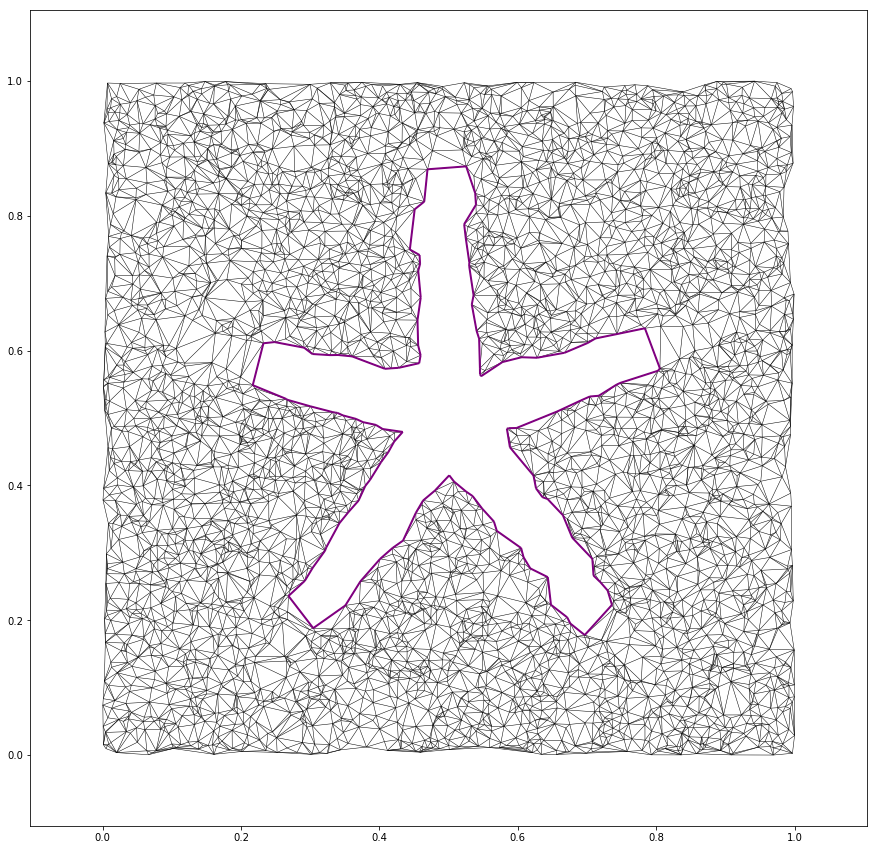

In [11]:
## Draw
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=0.5)
#nx.draw_networkx_edges(path_longest, pos=points, width=2.0, edge_color='red')
#nx.draw_networkx_edges(chull_exterior_hole, pos=points, width=2.0, edge_color='black')
nx.draw_networkx_edges(hole_exterior_graph, pos=points, width=2.0, edge_color='purple')
#plt.axis("off")
plt.show()

In [12]:
def getIntersection(line1, line2):
    l1=np.insert(line1, 1, -1)
    l2=np.insert(line2, 1, -1)
    x, y, z= np.cross(l1, l2)
    return np.hstack([x, y]) / z

def pointsToLine(pt1, pt2):
    m = float(pt2[1]-pt1[1])/float(pt2[0]-pt1[0])
    b = pt2[1]-m*pt2[0]
    return np.array([m, b])

def intersectsHole(edge_list, edge_segment, points_map_seg, points_map_edges):
    l = pointsToLine(points_map_seg[edge_segment[0]], points_map_seg[edge_segment[1]])
    for e in edge_list:
        l_current = pointsToLine(points_map_edges[e[0]], points_map_edges[e[1]])
        x = getIntersection(l.T, l_current.T)
        s1 = (points_map_seg[edge_segment[0]], points_map_seg[edge_segment[1]])
        s2 = (points_map_edges[e[0]], points_map_edges[e[1]])
        x_valid = (min(s1[0][0],s1[1][0]) < x[0] < max(s1[0][0],s1[1][0])) and (min(s2[0][0],s2[1][0]) < x[0] < max(s2[0][0],s2[1][0]))
        y_valid = (min(s1[0][1],s1[1][1]) < x[1] < max(s1[0][1],s1[1][1])) and (min(s2[0][1],s2[1][1]) < x[1] < max(s2[0][1],s2[1][1]))
        if x_valid and y_valid:
            return e
    return False

def lineInHull(line, end_points, hull):
    #for x in range(end_points[0][0]+0.1, end_points[0][1]-0.1, 0.1):
    x_min = min((end_points[0][0], end_points[0][1]))
    x_max = max((end_points[0][0], end_points[0][1]))
    poly = MultiPoint(hull).convex_hull
    count = 0
    for x in np.arange(x_min-0.01, x_max+0.01, 0.01):
        y = line[0]*x+line[1]
        if poly.contains(Point(x,y)):
            count += 1
        if count == 3:
            return True
    return False

In [13]:
## Dominating Set
def dsetGraph(graph, points):
    print("Size of original graph:", len(graph.nodes()))
    nodes_dset = dominating_set(graph)
    print("Size of dominating set:", len(nodes_dset))
    points_dset = [points[i] for i in nodes_dset]
    edges_dset = delGraph(points_dset)
    graph_dset = nx.Graph()
    graph_dset.add_edges_from(edges_dset)
    return (graph_dset, points_dset)

# Layer Generator
def generateNextLayer(current_layer, current_points):
    # generate dset based graph
    next_graph, next_points = dsetGraph(current_layer, current_points)
    # return generated layer
    return (next_graph, next_points)

def reduceLayer(current_graph, current_points, current_shape):
    copy_layer = current_graph.copy()
    for s in copy_layer.nodes():
        for t in copy_layer.neighbors(s):
            p = current_points[s]
            q = current_points[t]
            l = pointsToLine(p,q)
            if lineInHull(l,(p,q),current_shape.get_edges()):
                copy_layer.remove_edge(s,t)
            if current_shape.has_point(list(p)) and current_shape.has_point(list(q)):
                copy_layer.remove_edge(s,t)
    return copy_layer

def reduceLayerPoly(current_graph, current_points, current_poly):
    copied_graph = current_graph.copy()
    for edge in copied_graph.edges():
        p, q = current_points[edge[0]], current_points[edge[1]]
        edge_line = LineString([p,q])
        if edge_line.crosses(current_poly) or current_poly.contains(edge_line):
            copied_graph.remove_edge(*edge)
    return copied_graph

def fullLayerGenerator(udg, udg_points, counter=-1, shapes=None):
    layers = []
    current_layer = (udg, udg_points)
    next_layer = None
    while current_layer != None and counter != 0:
        next_layer = generateNextLayer(current_layer[0], current_layer[1])
        next_graph = next_layer[0]
        if shapes != None:
            for shape in shapes:
                next_graph = reduceLayerPoly(next_graph, next_layer[1], shape)
        next_layer = (next_graph, next_layer[1])
        layers.append(next_layer)
        current_layer = next_layer
        counter -= 1
        print("Counter:", counter)
    return layers

In [14]:
# Render layer
def renderLayers(layer_list, color_list=['green', 'blue', 'red', 'orange', 'purple', 'gray', 'white'], hole_components=None, hole_graph=None, cx_hull=None):
    plt.clf
    nx.draw_networkx_edges(layer_list[0][0], pos=layer_list[0][1], width=0.5)
    for i in range(len(layer_list[1:-1])):
        l = layer_list[i+1]
        nx.draw_networkx_nodes(l[0], pos=l[1], node_color=color_list[i])
    nx.draw_networkx(layer_list[-1][0], pos=layer_list[-1][1], node_color=color_list[len(layer_list[1:-1])], width=3.0)
    if cx_hull != None:
        cx_graph, cx_points = cx_hull
        nx.draw_networkx_edges(cx_graph, pos=cx_points, width=2.0, edge_color='purple')
    if hole_graph != None:
        nx.draw_networkx_edges(hole_graph, pos=point_map_l0, width=1.0, edge_color='purple')
    if hole_components != None:
        for c in hole_components:
            nx.draw_networkx_edges(c, pos=point_map_l0, width=3.0, edge_color='purple')
    l1_patch = mpatches.Patch(color=(0.3,0.8,0.3, 0.5), label='L1 Dominating Set')
    l2_patch = mpatches.Patch(color=(0,0.3,0.9), label='L2 Dominating Set')
    l3_patch = mpatches.Patch(color=(1,0,0), label='L3 Dominating Set')
    l4_patch = mpatches.Patch(color='orange', label='L4 Dominating Set')
    l5_patch = mpatches.Patch(color='purple', label='L5 Dominating Set')
    l6_patch = mpatches.Patch(color='gray', label='L6 Dominating Set')
    l7_patch = mpatches.Patch(color='white', label='L7 Dominating Set')
    plt.legend(handles=[l1_patch, l2_patch, l3_patch, l4_patch, l5_patch, l6_patch, l7_patch])
    plt.axis('off')
    plt.show()

In [15]:
hole_exterior_vertices = [points[v] for v in hole_exterior_graph if hole_exterior_graph.degree(v)>0]
hole_exterior_nodes = [v for v in hole_exterior_graph if hole_exterior_graph.degree(v)>0]
ordered_verts = []
ordered_nodes = []
start_vert = hole_exterior_nodes[0]
prev_vert = start_vert
curr_vert = hole_exterior_graph.neighbors(start_vert)[0]
while curr_vert != start_vert:
    ordered_verts.append(points[curr_vert])
    next_vert = [n for n in hole_exterior_graph.neighbors(curr_vert) if n != prev_vert][0]
    prev_vert = curr_vert
    curr_vert = next_vert
ordered_verts.append(points[start_vert])
hole_exterior_polygon = Polygon(ordered_verts)
hole_cxhull_polygon = Polygon(chull_exterior_points)

In [16]:
## Function to find graph of bounded points
def find_bounded_points(cx_polygon, all_points):
    bounded_nodes = dict()
    bounded_points = []
    for i in range(len(all_points)):
        p = Point(points[i])
        if cx_polygon.intersects(p):
            bounded_points.append(points[i])
            bounded_nodes[i] = points[i]
    return udg_graph.subgraph(bounded_nodes.keys())

In [17]:
## Create a subgraph of UDG
bounded_udg_graph = find_bounded_points(hole_cxhull_polygon, points)
print(len(udg_graph.nodes()))
print(len(bounded_udg_graph.nodes()))

4371
987


# Draw triangulation overlay
triangle_chain_graph = nx.Graph()
for triangle in triangle_chain:
    for e in triangle.get_edges():
        triangle_chain_graph.add_edge(*e)

In [18]:
hole_del_graph = nx.Graph()
hole_del_graph.add_edges_from(delGraph(bounded_points))

reduced_del_graph = reduceLayerPoly(hole_del_graph, bounded_points, hole_exterior_polygon)

##for region in triangle_chain:
##    reduced_del_graph = reduceLayer(hole_del_graph, bounded_points, region)

NameError: name 'bounded_points' is not defined

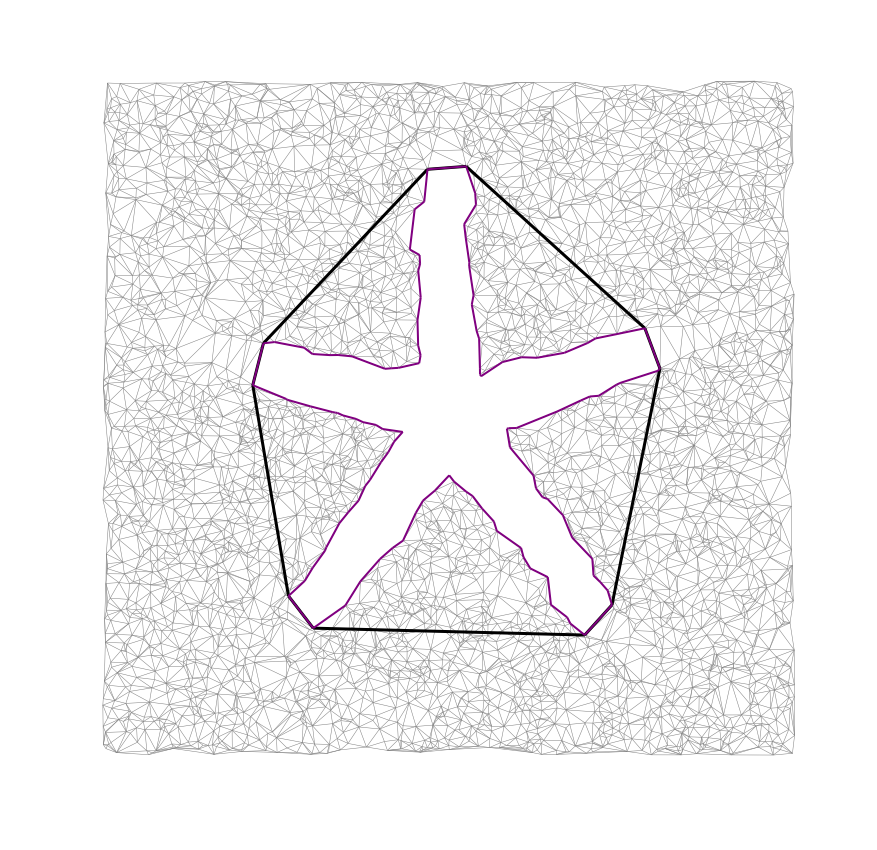

In [19]:
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=0.5, edge_color='gray')
#nx.draw_networkx_edges(bounded_udg_graph, pos=points, width=1.0)
nx.draw_networkx_edges(chull_exterior_hole, pos=points, width=3.0, edge_color='black')
#nx.draw_networkx_edges(reduced_del_graph, pos=bounded_points, edge_color='red', width=1.0)
nx.draw_networkx_edges(hole_exterior_graph, pos=points, width=2.0, edge_color='purple')
##nx.draw_networkx_edges(triangle_chain_graph, pos=points, width=2.0, edge_color='purple')
##nx.draw_networkx_edges(hole_del_graph, pos=bounded_points, edge_color='blue')

plt.axis("off")
plt.show()

In [20]:
# Dominating Set
dset_layers = fullLayerGenerator(bounded_udg_graph, points, counter=7, shapes=[hole_exterior_polygon])

Size of original graph: 987
Size of dominating set: 247
Counter: 6
Size of original graph: 247
Size of dominating set: 67
Counter: 5
Size of original graph: 67
Size of dominating set: 24
Counter: 4
Size of original graph: 24
Size of dominating set: 10
Counter: 3
Size of original graph: 10
Size of dominating set: 6
Counter: 2
Size of original graph: 6
Size of dominating set: 6
Counter: 1
Size of original graph: 6
Size of dominating set: 6
Counter: 0


In [21]:
pts = dset_layers[0][1]
p = pts[27]
q = pts[30]
ls = LineString([p,q])
print(ls.crosses(hole_exterior_polygon))
print(hole_exterior_polygon.contains(ls))
print(ls.disjoint(hole_exterior_polygon))

True
False
False


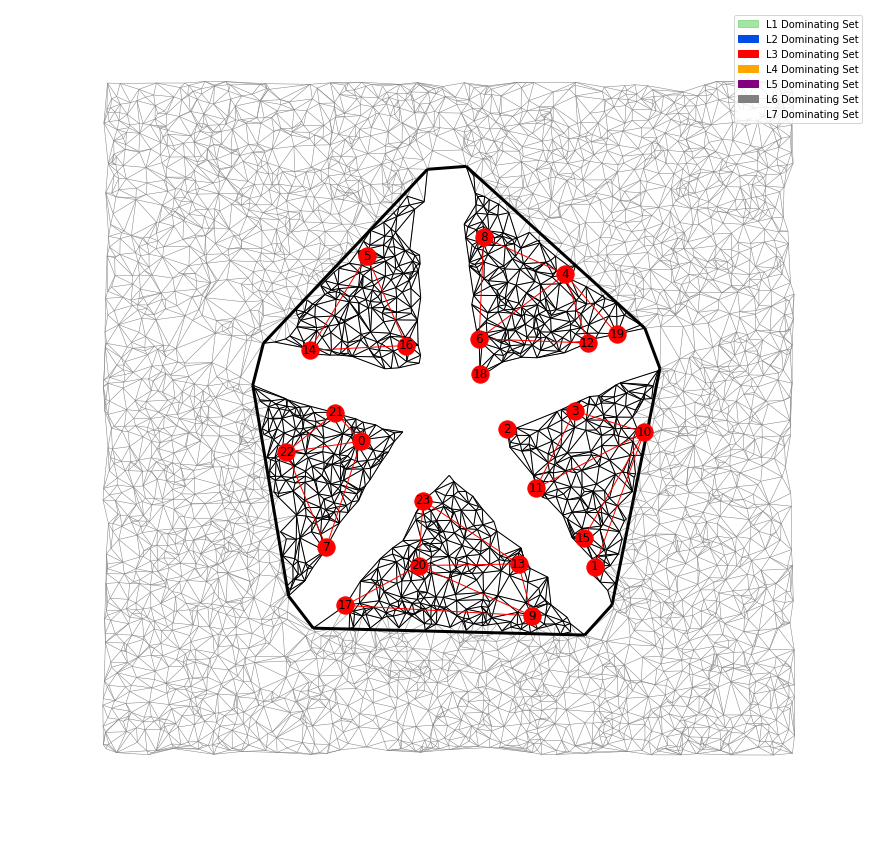

In [22]:
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=0.5, edge_color='gray')
nx.draw_networkx_edges(bounded_udg_graph, pos=points, width=1.0)
nx.draw_networkx_edges(chull_exterior_hole, pos=points, width=3.0, edge_color='black')
##nx.draw_networkx(dset_layers[0][0], pos=dset_layers[0][1], edge_color='green', node_color='green', width=1.0)
##nx.draw_networkx(dset_layers[1][0], pos=dset_layers[1][1], edge_color='blue', node_color='blue', width=1.0)
nx.draw_networkx(dset_layers[2][0], pos=dset_layers[2][1], edge_color='red', node_color='red', width=1.0)

l1_patch = mpatches.Patch(color=(0.3,0.8,0.3, 0.5), label='L1 Dominating Set')
l2_patch = mpatches.Patch(color=(0,0.3,0.9), label='L2 Dominating Set')
l3_patch = mpatches.Patch(color=(1,0,0), label='L3 Dominating Set')
l4_patch = mpatches.Patch(color='orange', label='L4 Dominating Set')
l5_patch = mpatches.Patch(color='purple', label='L5 Dominating Set')
l6_patch = mpatches.Patch(color='gray', label='L6 Dominating Set')
l7_patch = mpatches.Patch(color='white', label='L7 Dominating Set')
plt.legend(handles=[l1_patch, l2_patch, l3_patch, l4_patch, l5_patch, l6_patch, l7_patch])
plt.axis("off")
plt.show()

In [23]:
## Repeated Delaunay Triangulation

## Remove intersection points between convex hull and bounded udg graph
separated_bounded_udg = bounded_udg_graph.copy()
removed_nodes = []
for n in chull_exterior_hole.nodes():
    removed_nodes.append(n)
    separated_bounded_udg.remove_node(n)
    
## Find connected components of separated_bounded_udg
inverted_hole_components = list(nx.connected_component_subgraphs(separated_bounded_udg))
    
## Now reattach the removed nodes
for r in removed_nodes:
    for n in bounded_udg_graph.neighbors(r):
        ## Find which subgraph contains this neighbor
        for g in inverted_hole_components:
            if g.has_node(n):
                ## Connecte the removed node with an edge
                g.add_edge(r,n)

## Find convex hull of each component
inv_regions = []
for c in inverted_hole_components:
    cx = convexHull(c, points)
    inv_regions.append((c,cx))

## First stepping stone convex hull
## Find bounded points of each region
hull_region_pairs = []
for c in inv_regions:
    hull = c[1]
    hull_poly = Polygon(points[v] for v in hull.nodes())
    hull_bounded = []
    for n in bounded_udg_graph.nodes():
        if hull_poly.intersects(Point(points[n])):
            hull_bounded.append(n)
    hull_bounded_graph = bounded_udg_graph.subgraph(hull_bounded)
    hull_region_pairs.append((convexHull(hull_bounded_graph, points), hull_bounded_graph))
    
## Second convex hull
external_region_pairs = []
for h in hull_region_pairs:
    ext_path = externalPath(h[1])
    ext_path = h[1].subgraph(ext_path.nodes())
    cx_hull = convexHull(ext_path, points)
    external_region_pairs.append((cx_hull, ext_path))
    
## Find intersection points along inner edges
intersection_hull_pairs = []
for r in external_region_pairs:
    cx, g = r
    x_points = []
    x_nodes = []
    for node in cx:
        if g.has_node(node):
            x_points.append(points[node])
            x_nodes.append(node)
    x_graph = nx.Graph()
    for edge in delGraph(x_points):
        x_graph.add_edge(x_nodes[edge[0]], x_nodes[edge[1]])
    intersection_hull_pairs.append((cx, x_graph))
        
## Third (delaunay triangulation)
region_delaunay_pairs = []
for r in external_region_pairs:
    del_edges = delGraph([points[v] for v in r[1].nodes()])
    g = nx.Graph()
    for edge in del_edges:
        g.add_edge(r[1].nodes()[edge[0]], r[1].nodes()[edge[1]])
    region_delaunay_pairs.append((r[1], g))

## REVISED
## SECOND (2) CONVEX HULL -> Blue
## Find bounded points of each region
hull_region_pairs = []
for c in inv_regions:
    hull = c[1]
    hull_poly = Polygon(points[v] for v in hull.nodes())
    hull_bounded = []
    for n in bounded_udg_graph.nodes():
        if hull_poly.intersects(Point(points[n])):
            hull_bounded.append(n)
    hull_bounded_graph = bounded_udg_graph.subgraph(hull_bounded)
    hull_region_pairs.append((convexHull(hull_bounded_graph, points), hull_bounded_graph))

## For pairs of points (on interior) find shortest path along bounded graph
## then find convex hull of this hole (#3 -> red)
cx_interior_pairs = []
del_interior_pairs = []
for r in hull_region_pairs:
    cx, g = r
    ext_path = externalPath(g)
    weighted_bounded_graph = g.copy()
    edge_dists = dict()
    edge_degree = dict()
    for edge in weighted_bounded_graph.edges():
        edge_dists[edge] = euclideanDist(points[edge[0]], points[edge[1]])
        edge_degree[edge] = weighted_bounded_graph.degree(edge[0]) + weighted_bounded_graph.degree(edge[1])
    nx.set_edge_attributes(weighted_bounded_graph, 'distance', edge_dists)
    nx.set_edge_attributes(weighted_bounded_graph, 'degree', edge_degree)
    cx_interior_hulls = []
    del_interior_graph = nx.Graph()
    interior_region_vertices = []
    del_vertices = []
    for edge in cx.edges():
        if not chull_exterior_hole.has_edge(*edge):
            ## "Interior" edge of convex hull
            sp = nx.shortest_path(weighted_bounded_graph, source=edge[0], target=edge[1], weight='degree')
            if(len(sp)>2):
                cx_subgraph = g.subgraph(sp)
                cx_subgraph_hull = convexHull(cx_subgraph, points)
                cx_interior_hulls.append(cx_subgraph_hull)
                ## Keep track of interior vertices for polygon building later
                interior_region_vertices += [n for n in cx_subgraph_hull.nodes() if not n in interior_region_vertices]
                ## Add vertices to delaunay triangulation
                del_vertices += cx_subgraph_hull.nodes()
    invalid_region = Polygon([points[v] for v in interior_region_vertices])
    del_interior_pairs.append((g, del_interior_graph))
    cx_interior_pairs.append((g, cx_interior_hulls))

In [24]:
## For each component, select the nodes which are within convex hull
## and outside of component collection

bounded_chull_graph = convexHull(bounded_udg_graph, points)

weighted_bounded_graph = bounded_udg_graph.copy()
edge_dists = dict()
edge_degrees = dict()
for edge in weighted_bounded_graph.edges():
    edge_dists[edge] = euclideanDist(points[edge[0]], points[edge[1]])
    edge_degrees[edge] = weighted_bounded_graph.degree(edge[0]) + weighted_bounded_graph.degree(edge[1])
nx.set_edge_attributes(weighted_bounded_graph, 'distance', edge_dists)
nx.set_edge_attributes(weighted_bounded_graph, 'degree', edge_degrees)

component_pairs = []
for c in inv_regions:
    #c[1] -> convex hull of region
    cx = c[1]
    ## Find bounded nodes
    c_poly = Polygon([points[v] for v in c[1].nodes()])
    c_nodes = []
    for n in udg_graph.nodes():
        if c_poly.touches(Point(points[n])):
            c_nodes.append(n)
    c_graph = nx.Graph()
    for edge in c[1].edges():
        ## Check if this edge is "interior"
        if (bounded_chull_graph.has_edge(*edge)):
            #c_graph.add_edge(*edge)
            sp = nx.shortest_path(weighted_bounded_graph, source=edge[0], target=edge[1], weight='distance')
            for p in zip(sp, sp[1:]):
                c_graph.add_edge(*p)
        else:
            sp = nx.shortest_path(weighted_bounded_graph, source=edge[0], target=edge[1], weight='distance')
            for p in zip(sp, sp[1:]):
                c_graph.add_edge(*p)
    #(convex hull, combined graph)
    component_pairs.append((c[1], c_graph))

# Run this

In [25]:
## Start with edges of chull_exterior_hole
cx_interior_pairs = []
print('# edges', len(chull_exterior_hole.edges()))
for edge in chull_exterior_hole.edges():
    #Find internal subgraph (bounded)
    q = weighted_bounded_graph.copy()
    q.remove_nodes_from(edge)
    if len(list(nx.connected_components(q))) > 1:
        region_sp_len = float('inf')
        for c in nx.connected_component_subgraphs(q):
            e1 = False
            e1_n = None
            e2 = False
            e2_n = None
            for n in weighted_bounded_graph.neighbors(edge[0]):
                if c.has_node(n):
                    e1 = True
                    e1_n = n
            for n in weighted_bounded_graph.neighbors(edge[1]):
                if c.has_node(n):
                    e2 = True
                    e2_n = n
            if e1 and e2:
                sp_len = nx.shortest_path(c, source=e1_n, target=e2_n)
                if (len(sp_len) < region_sp_len):
                    region_sp_len = len(sp_len)
                    pt_count = len(c.nodes())
                    q = c
                    q.add_edge(edge[0], e1_n)
                    q.add_edge(edge[1], e2_n)
        ## For each edge pair, find path 'around' bounded nodes
        cx = convexHull(q, points)
        cx_interior_pairs.append((q,cx))
        
## Now take edges of cx_interior_pairs[1]
cx_sub_interior_pairs = []
for pair in cx_interior_pairs:
    g, cx = pair
    cx_interior_hulls = []
    for edge in cx.edges():
        if not chull_exterior_hole.has_edge(*edge):
            ## This is an 'interior', 'interior' edge
            sp = nx.shortest_path(g, source=edge[0], target=edge[1], weight='degree')
            if len(sp)>2:
                ## Create convex hull
                k = g.subgraph(sp)
                cx_k = convexHull(k, points)
                cx_interior_hulls.append((k, cx_k))
    cx_sub_interior_pairs.append((pair,cx_interior_hulls))
                
## Delaunay triangulation step
## Select 'blue' and 'red' vertices
## Iterate 'per region'
del_interior_pairs = []
for pair in cx_sub_interior_pairs:
    g, cx = pair[0]
    invalid_regions = []
    ## Restrict to this poly_region Polygon
    ## Find appropriate vertices
    del_nodes = []
    for i in pair[1]:
        cx_k = i[1]
        invalid_regions.append(Polygon([points[v] for v in cx_k.nodes()]))
        del_nodes += i[1].nodes()
    del_nodes += cx.nodes()
    ## Calculate delaunay triangulation
    del_points = [points[v] for v in del_nodes]
    del_edges = delGraph(del_points)
    d = nx.Graph()
    for edge in del_edges:
        valid = True
        ##for poly in invalid_regions:
            ##if poly.contains(LineString([del_points[edge[0]], del_points[edge[1]]])):
            ##    valid = False
        for poly in polys:
            if poly.intersects(LineString([del_points[edge[0]], del_points[edge[1]]])):
                valid = False
        if valid:
            d.add_edge(del_nodes[edge[0]], del_nodes[edge[1]])
    del_interior_pairs.append((cx, d))

# edges 10


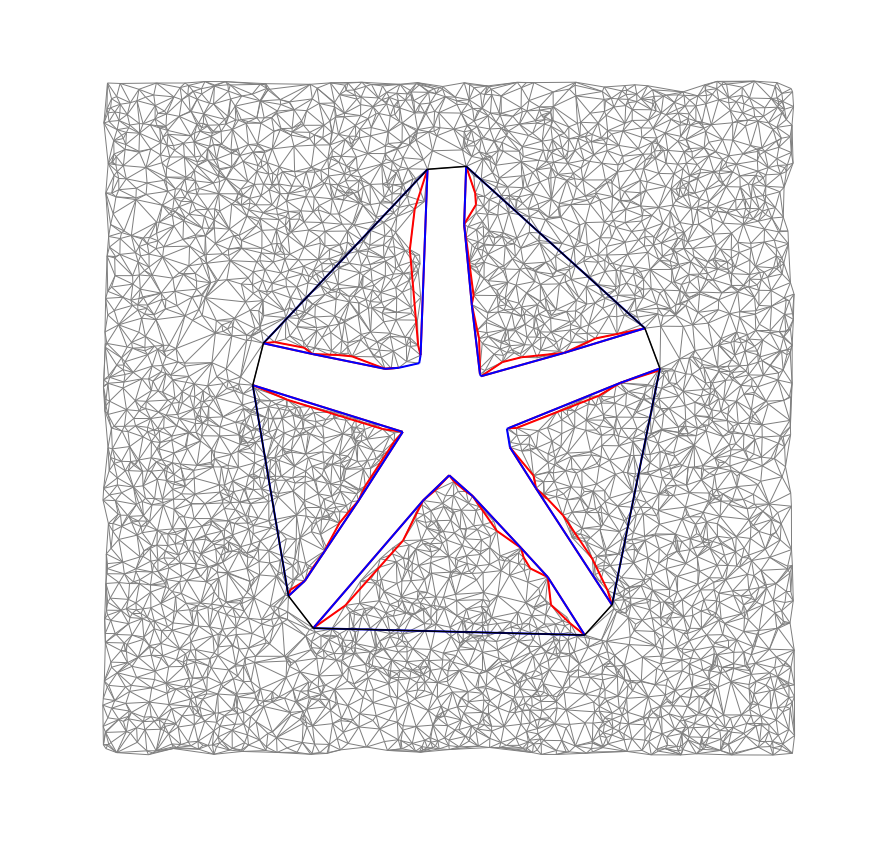

In [28]:
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=1.0, edge_color='gray')
##for r in del_interior_pairs:
##    nx.draw_networkx_edges(r[1], pos=points, edge_color='purple', width=2.0)
for r in cx_sub_interior_pairs:
    for i in r[1]:
        nx.draw_networkx_edges(i[1], pos=points, edge_color='red', width=2.0)
for r in cx_interior_pairs:
    ##nx.draw_networkx_edges(r[0], pos=points, edge_color='orange')
    nx.draw_networkx_edges(r[1], pos=points, edge_color='blue', width=2.0)
nx.draw_networkx_edges(chull_exterior_hole, pos=points,width=1.5, edge_color='black')
plt.axis("off")
plt.show()

In [27]:
## Second layer (recursive)

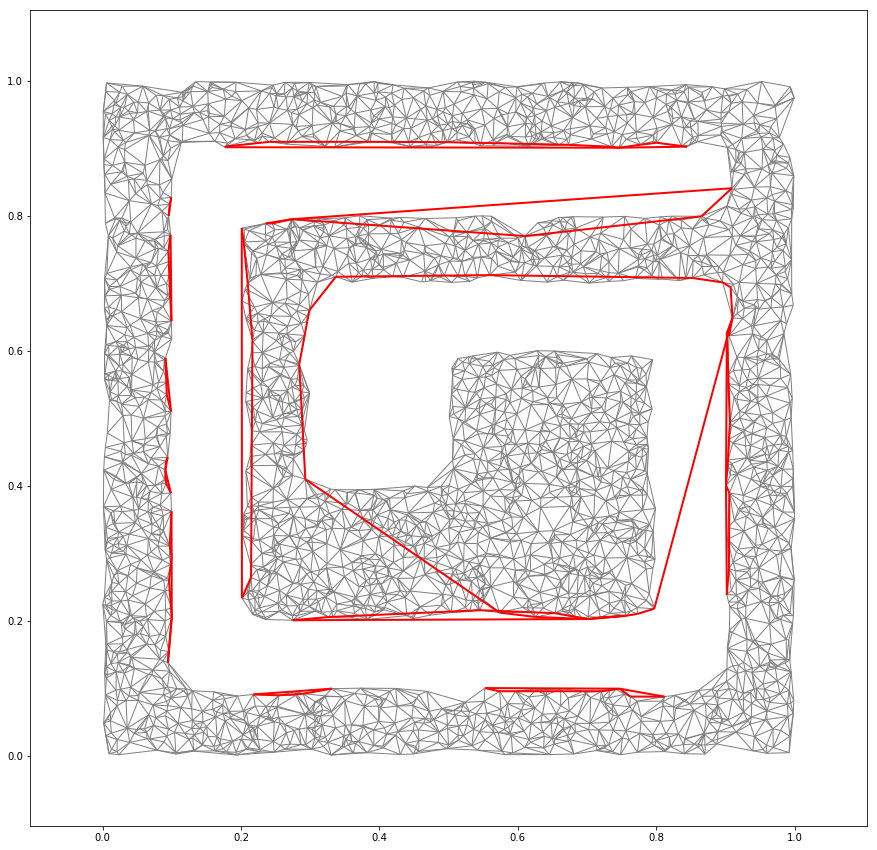

In [147]:
## Display / plot
plt.clf
nx.draw_networkx_edges(udg_graph, pos=points, width=1.0, edge_color='gray')
for r in cx_sub_interior_pairs:
    for i in r[1]:
        nx.draw_networkx_edges(i[1], pos=points, edge_color='red', width=2.0)
plt.show()